In [1]:
# Define the directory where your texts are stored
from llama3 import config
import os
data_dir = os.path.join("POP_en_txt", "KARNATAKA")
data_path = os.path.join(config.DATA_DIR, data_dir)
n_splits = 1
split_size = 1/n_splits


In [2]:
import os
from datasets import Dataset

def read_files_to_dicts(data_dir):
    file_contents = []
    for root, dirs, files in os.walk(data_dir):
            for filename in files:
                # print(filename)
                file_path = os.path.join(root, filename)
                if os.path.isfile(file_path):
                    with open(file_path, encoding="utf-8") as file:
                        content = file.read()
                    file_contents.append({"text": content})
    return file_contents

# Read all files into a list of dictionaries with their content
file_content_dicts = read_files_to_dicts(data_path)

# Create a Dataset from the list of dictionaries
# checking length to discard curropted inputs
agrids = Dataset.from_dict({"text": [x["text"] for x in file_content_dicts if len(x["text"]) < 8172411]})

def remove_newlines(batch):
    batch["text"] = [text.replace("\n", " ") for text in batch["text"]]
    # batch["len"] = [len(text) for text in batch["text"]]
    return batch

agrids = agrids.map(
    remove_newlines,
    batched=True,
    num_proc=32,
)

Map (num_proc=32):   0%|          | 0/219 [00:00<?, ? examples/s]

In [3]:
agridata = agrids.shuffle(seed=42)

In [5]:
# Get total number of samples
num_samples = len(agridata)

# Calculate split size for 5 splits
split_size = num_samples // n_splits

# Create splits
splits = []
for i in range(n_splits):
    start = i * split_size
    end = start + split_size
    splits.append(agridata.select(range(start, end)))

In [6]:
from datasets import DatasetDict

# Assuming you have the list of splits from the previous code
splits_dict = DatasetDict({
    f"split_{i + 1}": split for i, split in enumerate(splits)
})

In [7]:
splits_dict

DatasetDict({
    split_1: Dataset({
        features: ['text'],
        num_rows: 219
    })
})

In [8]:
agridata = splits_dict

In [9]:
from transformers import AutoTokenizer
from llama3.utils import get_llama3_tokenizer

tokenizer = get_llama3_tokenizer()

/data2/home/sahilkamble/anaconda3/envs/project/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [10]:
tokenized_data = agridata.map(
    lambda batch: tokenizer(batch["text"], max_length=4096, truncation=True),
    batched=True,
    num_proc=32,
    remove_columns=agridata['split_1'].column_names
)

Map (num_proc=32):   0%|          | 0/219 [00:00<?, ? examples/s]

In [11]:
tokenized_data

DatasetDict({
    split_1: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 219
    })
})

In [12]:
tokenized_data.save_to_disk(f"./{data_dir}_processed_dataset_llama_3_8B_instruct")

Saving the dataset (0/1 shards):   0%|          | 0/219 [00:00<?, ? examples/s]

In [ ]:
from datasets import load_from_disk, concatenate_datasets

data = load_from_disk("./processed_dataset_llama_2/")
train_data = concatenate_datasets([data["split_1"], data["split_2"], data["split_3"], data["split_4"], data["split_5"]])

train_data

/home/sahilkamble/.local/lib/python3.11/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 6535
})

In [ ]:
train_data = train_data.to_pandas()

In [ ]:
train_data['len'] = [len(i) for i in train_data['input_ids']]

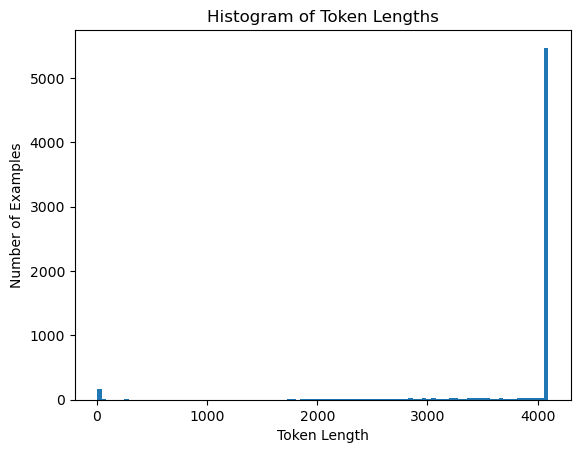

In [ ]:
import matplotlib.pyplot as plt

plt.hist(train_data['len'], bins=100)
plt.title('Histogram of Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('Number of Examples')
plt.show()